In [1]:
from dask.distributed import Client, progress
dask_client = Client(threads_per_worker=10, n_workers=4)
dask_client

Client Scheduler: tcp://127.0.0.1:40761 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 40 Memory: 99.69 GB


In [ ]:
dask_client.shutdown()


In [2]:
import dask_image.imread
import dask_image.ndfilters
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import dask
from skimage.io import imsave, imread
import dask
import dask.array as da
from scipy.signal import convolve2d
from skimage.feature import peak_local_max
from pathlib import Path
from PIL import Image
import matplotlib.patches as patches

In [3]:
def da_imsave(fnames, arr, compute=False):
    """Write arr to a stack of images assuming
    the last two dimensions of arr as image dimensions.
    
    Parameters
    ----------
    fnames: string
        A formatting string like 'myfile{:02d}.png'
        Should support arr.ndims-2 indices to be formatted
    arr: dask.array
        Array of at least 2 dimensions to be written to disk as images
    compute: Boolean (optional)
        whether to write to disk immediately or return a dask.array of the to be written indices
    
    """
    indices = [da.arange(n, chunks=c) for n,c in zip(arr.shape[:-2], arr.chunksize[:-2])]
    index_array = da.stack(da.meshgrid(*indices,indexing='ij'), axis=-1).rechunk({-1:-1})

    @da.as_gufunc(signature=f"(i,j),({arr.ndim-2})->({arr.ndim-2})", output_dtypes=int, vectorize=True)
    def saveimg(image, index):
        im = Image.fromarray(image.squeeze().astype(np.uint32))
        im.save(fnames.format(*index))
        return index
    
    res = saveimg(arr,index_array)
    if compute == True:
        res.compute()
    else:
        return res

In [4]:
@da.as_gufunc(signature=f"(i,j),(),(),()->(i,j)", output_dtypes=int, vectorize=True, allow_rechunk=True)
def max_of_clusters_var_cl_th_dis(img, cl, th, dis):
    mask = np.ones([cl,cl])
    clusters_scipy = convolve2d(img, mask, mode='same', fillvalue=0)
    maxima = peak_local_max(clusters_scipy, min_distance=dis, threshold_abs=th)
    max_value_mask = np.zeros([400,400])
    max_value_mask[maxima[:,0], maxima[:,1]] = 1
    max_clusts = clusters_scipy * max_value_mask
    return max_clusts

In [5]:
@da.as_gufunc(signature=f"(i,j),(),(),()->(i,j)", output_dtypes=int, vectorize=True, allow_rechunk=True)
def single_photon_mask_var_cl_th_dis(img, cl, th, dis):
    mask = np.ones([cl,cl])
    clusters_scipy = convolve2d(img, mask, mode='same', fillvalue=0)
    maxima = peak_local_max(clusters_scipy, min_distance=dis, threshold_abs=th)
    max_value_mask = np.zeros([400,400])
    max_value_mask[maxima[:,0], maxima[:,1]] = 1
    return max_value_mask

In [6]:
@da.as_gufunc(signature=f"(i,j),(),()->(i,j)", output_dtypes=int, vectorize=True)
def max_of_clusters_var_cl_th_counts(img, cl, th):
    mask = np.ones([cl,cl])
    clusters_scipy = convolve2d(img, mask, mode='same', fillvalue=0)
    maxima = peak_local_max(clusters_scipy, min_distance=cl, threshold_abs=th)
    max_value_mask = np.zeros([400,400])
    max_value_mask[maxima[:,0], maxima[:,1]] = 1
    max_clusts = clusters_scipy * max_value_mask
    counts = max_value_mask.sum(axis=(0,1))
    return max_clusts

In [7]:
@da.as_gufunc(signature=f"(i,j),(),()->()", output_dtypes=int, vectorize=True)
def cluster_counts_cl_th(img, cl, th):
    mask = np.ones([cl,cl])
    clusters_scipy = convolve2d(img, mask, mode='same', fillvalue=0)
    maxima = peak_local_max(clusters_scipy, min_distance=cl, threshold_abs=th)
    return len(maxima)

# Loading pedestals

In [10]:
dark_0 = r'/mnt/nvme_ssd/220307_captures_repeat_from_220304/ped_0/*/*'
dark_images = dask_image.imread.imread(dark_0, arraytype="numpy")
avg_dark = da.average(dark_images, axis=0)

In [13]:
avg_dark_comp = avg_dark.compute() # init dark capture from static 10000 frames

In [12]:
imsave("070322_misc_files/ped_0.tiff", dark_avg_old_comptured)

In [15]:
dark_images_1000 = dark_images[:1000] - avg_dark_comp

In [16]:
dark_images_1000_comp = dark_images_1000.compute()

In [17]:
print(f'std {np.std(dark_images_1000_comp)}')

std 20.636150360107422


# Loading pre-calculated pedestal

In [8]:
avg_dark_comp = imread("070322_misc_files/ped_0.tiff")

# Fitting noise

In [14]:
dark_minus_ped = dark_images - avg_dark_old

In [27]:
dark_minus_ped.shape

(9973, 400, 400)

In [15]:
bins_noise = np.arange(-100, 100)

In [16]:
noise_hist, b = da.histogram(dark_minus_ped.flatten(), bins_noise)

In [ ]:
noise_hist_comp = noise_hist.compute()

In [17]:
import lmfit
from lmfit.models import GaussianModel

In [ ]:
mod = GaussianModel()
x = np.arange(-100, 99)
params = mod.guess(noise_hist_comp/26000, x=x)
result = mod.fit(data=noise_hist_comp/26000, params=params, x=x)
print(result.fit_report())

In [18]:
noise_sim_26000 = da.random.normal(loc=-0.5, scale=19.94, size=(26000,400,400))
noise_hist_sim, b = da.histogram(noise_sim_26000.flatten(), bins_noise)

In [ ]:
noise_hist_sim_comp = noise_hist_sim.compute()

In [ ]:
%matplotlib notebook
plt.plot(x, noise_hist_comp/10000, )
#plt.plot(x, result.best_fit*26000, label='gaus fit')
plt.plot(x, noise_hist_sim_comp/26000, label='simulated noise')
plt.legend()

# Evaluation of captures

## Dark evaluation ring search

In [244]:
init_dark = r'/mnt/nvme_ssd/220304_captures/220304_run_d0_f0_14[4-5]_*'
dark_images = dask_image.imread.imread(init_dark, arraytype="numpy")
dark_images_minus_avg = dark_images - dark_avg_old_comptured

In [273]:
THRESHOLD = 150

In [288]:
th_mask =  dark_images_minus_avg[:1000] > THRESHOLD # boolean mask for each frame
images_th_masked = th_mask # apply mask

In [289]:
sum_th_images = images_th_masked.sum(axis=0)

In [290]:
sum_th_images_comp = sum_th_images.compute()

<IPython.core.display.Javascript object>


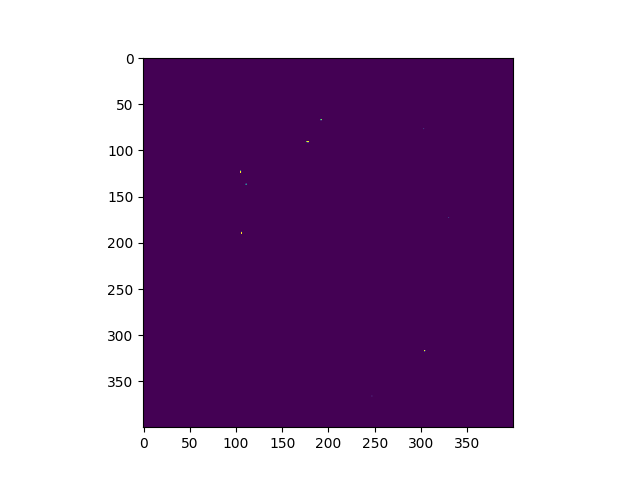

In [291]:
%matplotlib notebook
plt.imshow(sum_th_images_comp, vmax=5)

In [292]:
im = Image.fromarray(sum_th_images_comp.astype(np.uint32))
im.save("220430_pictures/noist_th_150/noise_th_150_1000.tiff")


### 2x2

#### Mask only (assume all pixels are single pixels

In [303]:
dark_clustered_2x2 = single_photon_mask_var_cl_th_dis(dark_images_minus_avg[:1000], 2, 200, 1)

In [304]:
sum_dark_clustered_2x2 = dark_clustered_2x2.sum(axis=0)

In [305]:
sum_dark_clustered_2x2_comp = sum_dark_clustered_2x2.compute()

<IPython.core.display.Javascript object>


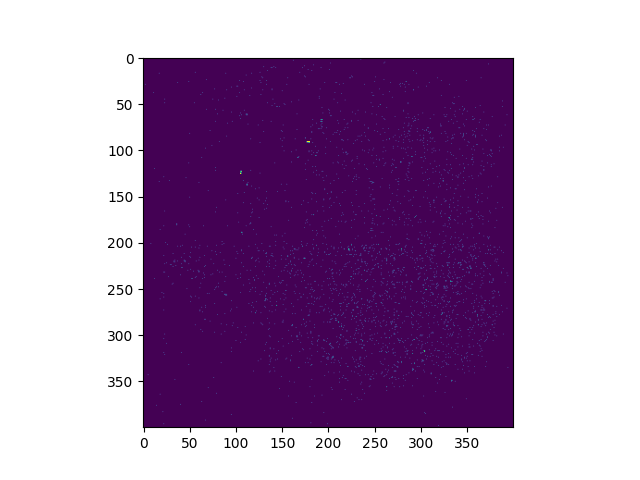

In [306]:
%matplotlib notebook
plt.imshow(sum_dark_clustered_2x2_comp, vmax=5)

In [307]:
im = Image.fromarray(sum_dark_clustered_2x2_comp.astype(np.uint32))
im.save("220430_pictures/noise_cl_2_th_200/single_count_mask_cl_2_th_200_sum_1000.tiff")


# Loading captures

In [9]:
filename_pattern = r'/mnt/nvme_ssd/220307_captures_repeat_from_220304/stray_0/*/*'
images = dask_image.imread.imread(filename_pattern, arraytype="numpy")

In [10]:
images_minus_dark_old = images - avg_dark_comp

## Ring evaluation

In [11]:
images_minus_dark_old.shape

(56558, 400, 400)

### No filter

In [113]:
images_minus_dark_old_short = images_minus_dark_old[:50000]

In [114]:
sum_images = images_minus_dark_old_short.sum(axis=0)

In [115]:
sum_images_comp = sum_images.compute()

<IPython.core.display.Javascript object>


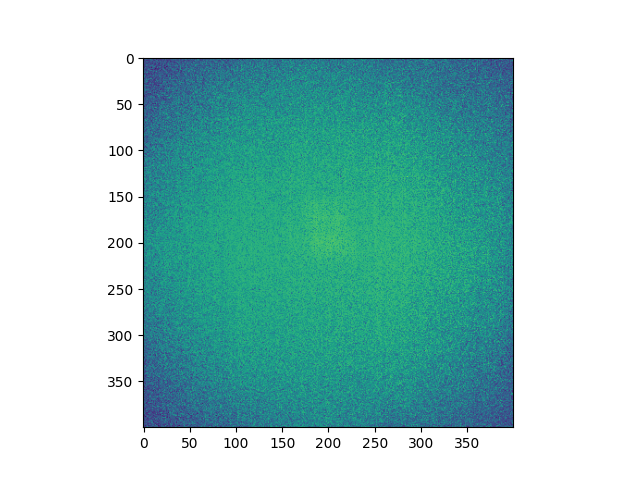

In [116]:
%matplotlib notebook
plt.imshow(sum_images_comp)

In [117]:
im = Image.fromarray(sum_images_comp.astype(np.uint32))
im.save("220501_pictures/no_filter_resonance/070322_no_filter_sum_50000.tiff")


### Thresholding

In [48]:
images_minus_dark_old_short = images_minus_dark_old[:50000]

In [49]:
th_mask = images_minus_dark_old_short > 180 # boolean mask for each frame
images_th_masked = th_mask # apply mask

In [50]:
sum_th_images = images_th_masked.sum(axis=0)

In [51]:
sum_th_images_comp = sum_th_images.compute()

<IPython.core.display.Javascript object>


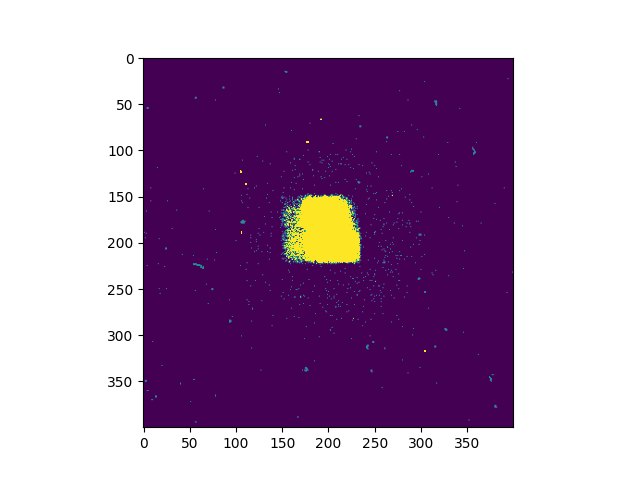

In [52]:
%matplotlib notebook
plt.imshow(sum_th_images_comp, vmax=2)

In [53]:
im = Image.fromarray(sum_th_images_comp.astype(np.uint32))
im.save("220501_pictures/th_180_resonance/single_count_mask_only_th_180_sum_50000.tiff")


### partial sums save

In [151]:
partial_sums_th_150 = images_th_masked.cumsum(axis=0)

In [152]:
filename = '/mnt/nvme_ssd/partialsums_th_150/partial_sum_th_150_50000_{:d}.tiff'
da_imsave(filename, partial_sums_th_150, compute=True)

### Clusterisation + thresholding

### 2x2

#### Mask only (assume all pixels are single pixels

In [111]:
single_photons_clustered_2x2 = single_photon_mask_var_cl_th_dis(images_minus_dark_old[:50000], 2, 200, 1)

In [112]:
sum_single_photons_clustered_2x2 = single_photons_clustered_2x2.sum(axis=0)

In [113]:
sum_single_photons_clustered_2x2_comp = sum_single_photons_clustered_2x2.compute()

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


<IPython.core.display.Javascript object>


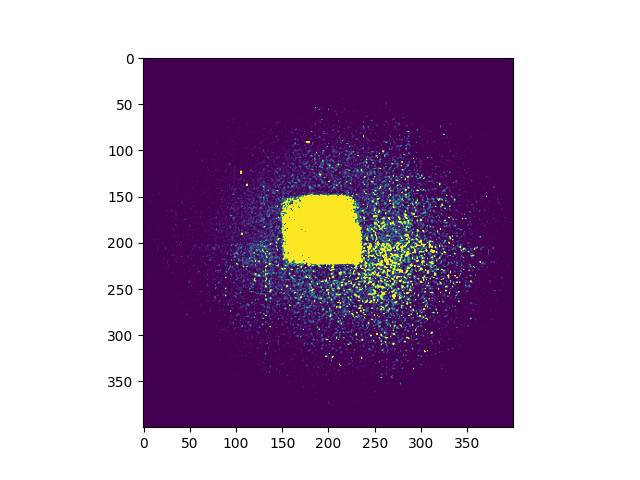

In [115]:
%matplotlib notebook
plt.imshow(sum_single_photons_clustered_2x2_comp, vmax=20)

In [116]:
im = Image.fromarray(sum_single_photons_clustered_2x2_comp.astype(np.uint32))
im.save("220501_pictures/cl_2_th_200_resonance/single_count_mask_cl_2_th_200_sum_50000.tiff")


### 3x3

#### Mask only (assume all pixels are single pixels

In [234]:
single_photons_clustered_3x3 = single_photon_mask_var_cl_th_dis(images_minus_dark_old[:50000], 3, 350, 2)

In [235]:
sum_single_photons_clustered_3x3 = single_photons_clustered_3x3.sum(axis=0)

In [236]:
sum_single_photons_clustered_3x3_comp = sum_single_photons_clustered_3x3.compute()

<IPython.core.display.Javascript object>


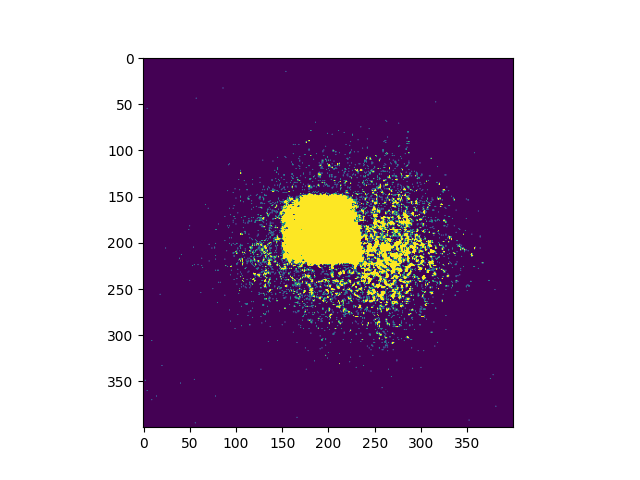

In [237]:
%matplotlib notebook
plt.imshow(sum_single_photons_clustered_3x3_comp, vmax=2)

In [238]:
im = Image.fromarray(sum_single_photons_clustered_3x3_comp.astype(np.uint32))
im.save("220501_pictures/cl_3_th_350_resonance/single_count_mask_cl_3_th_350_sum_50000.tiff")


### partial sums save

In [147]:
partial_sums_cl_2 = single_photons_clustered_2x2.cumsum(axis=0)

In [148]:
filename = '/mnt/nvme_ssd/partialsums/partial_sum_cl2_th_180_50000_{:d}.tiff'
da_imsave(filename, partial_sums_cl_2, compute=True)

## Histograms

In [239]:
bins = np.arange(-200, 1000)

In [240]:
dark_0 = r'/mnt/nvme_ssd/220307_captures_repeat_from_220304/ped_0/*/*'
dark_images = dask_image.imread.imread(dark_0, arraytype="numpy")
avg_dark = da.average(dark_images, axis=0)

Limiting images amount to 9700

In [241]:
dark_images.shape

(20004, 400, 400)

In [252]:
dark_images_minus_dark_old = dark_images[:10000] - avg_dark_comp
dark_images_cl_2x2_old = max_of_clusters_var_cl_th_dis(dark_images_minus_dark_old[:10000], 2, -250, 1)
dark_images_cl_3x3_old = max_of_clusters_var_cl_th_dis(dark_images_minus_dark_old[:10000], 3, -250, 2)


images_minus_dark_old_no_filter = images_minus_dark_old[:10000]
images_cl_2x2_old = max_of_clusters_var_cl_th_dis(images_minus_dark_old[:10000], 2, -250, 1)
images_cl_3x3_old = max_of_clusters_var_cl_th_dis(images_minus_dark_old[:10000], 3, -250, 2)

In [253]:
dark_images_minus_dark_old_hist, _ = da.histogram(dark_images_minus_dark_old.flatten(), bins)
dark_images_cl_2x2_old_hist, _ = da.histogram(dark_images_cl_2x2_old.flatten(), bins)
dark_images_cl_3x3_old_hist, _ = da.histogram(dark_images_cl_3x3_old.flatten(), bins)


images_minus_dark_old_no_filter_hist, _ = da.histogram(images_minus_dark_old_no_filter.flatten(), bins)
images_cl_2x2_dark_old_hist, _ = da.histogram(images_cl_2x2_old.flatten(), bins)
images_cl_3x3_dark_old_hist, _ = da.histogram(images_cl_3x3_old.flatten(), bins)

In [254]:
dark_images_minus_dark_old_hist_comp = dark_images_minus_dark_old_hist.compute()

In [255]:
dark_images_cl_2x2_old_hist_comp = dark_images_cl_2x2_old_hist.compute()

In [256]:
dark_images_cl_3x3_old_hist_comp = dark_images_cl_3x3_old_hist.compute()

In [248]:
images_minus_dark_old_no_filter_hist_comp = images_minus_dark_old_no_filter_hist.compute()

In [249]:
images_cl_2x2_dark_old_hist_comp = images_cl_2x2_dark_old_hist.compute()

In [250]:
images_cl_3x3_dark_old_hist_comp = images_cl_3x3_dark_old_hist.compute()

<IPython.core.display.Javascript object>


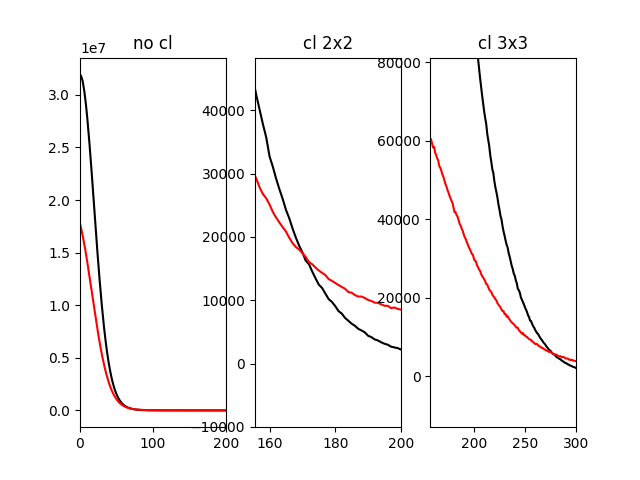

In [257]:
%matplotlib notebook
plot_x = np.arange(-200, 999)
plt.subplot(1,3,1)
plt.xlim(0, 200)
plt.title('no cl')
plt.plot(plot_x, dark_images_minus_dark_old_hist_comp,color = 'black', label ='noise no cl')
plt.plot(plot_x, images_minus_dark_old_no_filter_hist_comp, color= 'red', label = 'signal no cl')

plt.subplot(1,3,2)
plt.xlim(0, 200)
plt.title('cl 2x2')
plt.plot(plot_x, dark_images_cl_2x2_old_hist_comp, color= 'black', label ='noise cl 2x2')
plt.plot(plot_x, images_cl_2x2_dark_old_hist_comp, color= 'red', label = 'signal cl 2x2')

plt.subplot(1,3,3)
plt.title('cl 3x3')
plt.xlim(0, 300)
plt.plot(plot_x, dark_images_cl_3x3_old_hist_comp, color= 'black', label ='noise cl 3x3')

plt.plot(plot_x, images_cl_3x3_dark_old_hist_comp, color= 'red' ,label = 'signal cl 3x3')
#plt.legend()

<IPython.core.display.Javascript object>


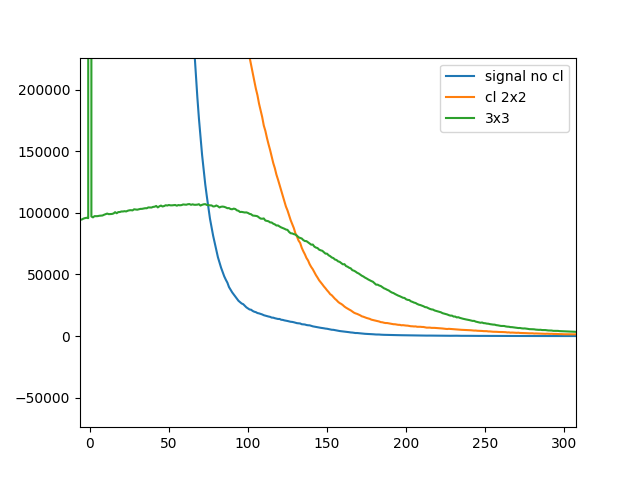

In [264]:
%matplotlib notebook
plt.plot(plot_x, images_minus_dark_old_no_filter_hist_comp, label = 'signal no cl')
plt.plot(plot_x, images_cl_2x2_dark_old_hist_comp, label = 'cl 2x2')
plt.plot(plot_x, images_cl_3x3_dark_old_hist_comp, label ='3x3')
plt.legend()

In [258]:
np.savetxt('noise_hist_070322.csv',
           np.column_stack((plot_x,
                            dark_images_minus_dark_old_hist_comp,
                            dark_images_cl_2x2_old_hist_comp,
                            dark_images_cl_3x3_old_hist_comp)),
           header="hist bins, noise, noise 2x2 cl, noise 3x3 cl",
           delimiter=",")

In [259]:
np.savetxt('signal_hist_070322.csv',
           np.column_stack((plot_x,
                            images_minus_dark_old_no_filter_hist_comp,
                            images_cl_2x2_dark_old_hist_comp,
                            images_cl_3x3_dark_old_hist_comp)),
           header="hist bins, signal, signal 2x2 cl, signal 3x3 cl",
           delimiter=",")

# off resonant 

## Loading pedestals

In [47]:
dark_1 = r'/mnt/nvme_ssd/220307_captures_repeat_from_220304/ped_1/*/*'
dark_images = dask_image.imread.imread(dark_1, arraytype="numpy")
avg_dark = da.average(dark_images, axis=0)

In [48]:
avg_dark_comp = avg_dark.compute() # init dark capture from static 10000 frames

In [50]:
imsave("070322_misc_files/ped_1.tiff", avg_dark_comp)

In [51]:
dark_images_1000 = dark_images[:1000] - avg_dark_comp

In [52]:
dark_images_1000_comp = dark_images_1000.compute()

In [53]:
print(f'std {np.std(dark_images_1000_comp)}')

std 21.205991744995117


## Loading pre-calculated pedestal

In [260]:
avg_dark_comp = imread("070322_misc_files/ped_1.tiff")

## Loading captures

In [265]:
filename_pattern = r'/mnt/nvme_ssd/220307_captures_repeat_from_220304/stray_off_resonant_1/*/*'
images = dask_image.imread.imread(filename_pattern, arraytype="numpy")

In [266]:
images_minus_dark_old = images - avg_dark_comp

### Thresholding

In [57]:
THRESHOLD = 150

In [297]:
images_minus_dark_old_short = images_minus_dark_old[:50000]

In [298]:
th_mask = images_minus_dark_old_short > 150 # boolean mask for each frame
images_th_masked = th_mask # apply mask

In [299]:
sum_th_images = images_th_masked.sum(axis=0)

In [300]:
sum_th_images_comp = sum_th_images.compute()

<IPython.core.display.Javascript object>


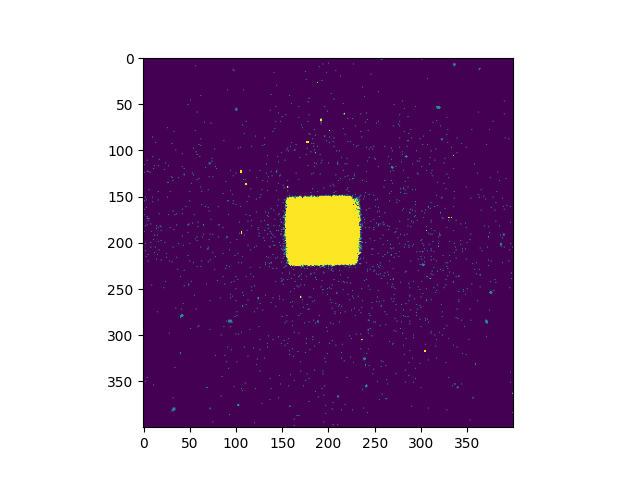

In [301]:
%matplotlib notebook
plt.imshow(sum_th_images_comp, vmax=2)

In [302]:
im = Image.fromarray(sum_th_images_comp.astype(np.uint32))
im.save("220501_pictures/th_150_off_resonance/single_count_mask_only_th_150_sum_50000.tiff")


### partial sums save

In [151]:
partial_sums_th_150 = images_th_masked.cumsum(axis=0)

In [152]:
filename = '/mnt/nvme_ssd/partialsums_th_150/partial_sum_th_150_50000_{:d}.tiff'
da_imsave(filename, partial_sums_th_150, compute=True)

### Clusterisation + thresholding

In [51]:
CL_THRESHOLD_2x2 = 180 # 2*sigma*5 = 200
CL_THRESHOLD_3x3 = 200 # 3*sigma*5 = 300?


### 2x2

#### Mask only (assume all pixels are single pixels

In [354]:
single_photons_clustered_2x2 = single_photon_mask_var_cl_th_dis(images_minus_dark_old[:50000], 2, 200, 1)

In [355]:
sum_single_photons_clustered_2x2 = single_photons_clustered_2x2.sum(axis=0)

In [356]:
sum_single_photons_clustered_2x2_comp = sum_single_photons_clustered_2x2.compute()

<IPython.core.display.Javascript object>


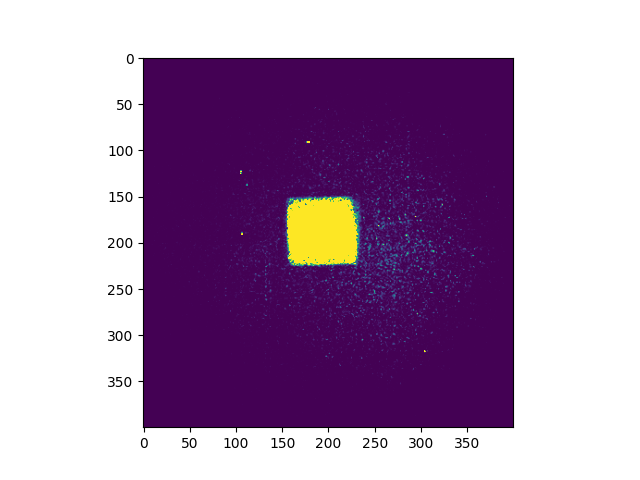

In [360]:
%matplotlib notebook
plt.imshow(sum_single_photons_clustered_2x2_comp, vmax=100)

In [358]:
im = Image.fromarray(sum_single_photons_clustered_2x2_comp.astype(np.uint32))
im.save("220501_pictures/cl_2_th_200_off_resonance/single_count_mask_cl_2_th_200_sum_50000.tiff")


# dark captures

## Loading pedestals

In [47]:
dark_1 = r'/mnt/nvme_ssd/220307_captures_repeat_from_220304/ped_1/*/*'
dark_images = dask_image.imread.imread(dark_1, arraytype="numpy")
avg_dark = da.average(dark_images, axis=0)

In [48]:
avg_dark_comp = avg_dark.compute() # init dark capture from static 10000 frames

In [50]:
imsave("070322_misc_files/ped_1.tiff", avg_dark_comp)

In [51]:
dark_images_1000 = dark_images[:1000] - avg_dark_comp

In [52]:
dark_images_1000_comp = dark_images_1000.compute()

In [53]:
print(f'std {np.std(dark_images_1000_comp)}')

std 21.205991744995117


## Loading pre-calculated pedestal

In [362]:
avg_dark_comp = imread("070322_misc_files/ped_1.tiff")

## Loading captures

In [363]:
dark_1 = r'/mnt/nvme_ssd/220307_captures_repeat_from_220304/ped_1/*/*'
images = dask_image.imread.imread(dark_1, arraytype="numpy")

In [364]:
images_minus_dark_old = images - avg_dark_comp

In [365]:
images_minus_dark_old.shape

(25005, 400, 400)

### Thresholding

In [57]:
THRESHOLD = 150

In [366]:
images_minus_dark_old_short = images_minus_dark_old[:25000]

In [367]:
th_mask = images_minus_dark_old_short > 150 # boolean mask for each frame
images_th_masked = th_mask # apply mask

In [368]:
sum_th_images = images_th_masked.sum(axis=0)

In [369]:
sum_th_images_comp = sum_th_images.compute()

<IPython.core.display.Javascript object>


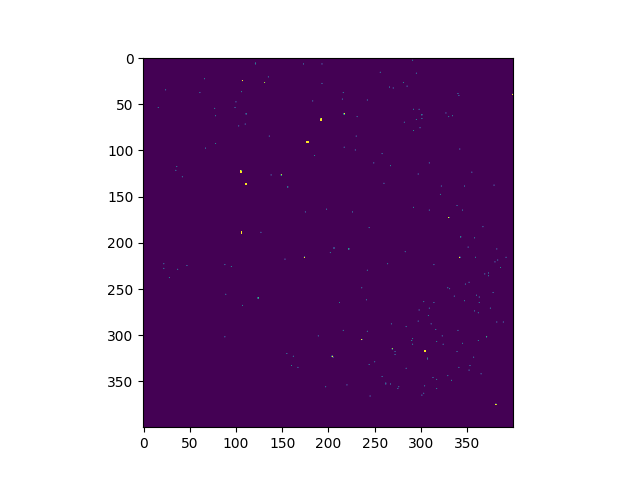

In [370]:
%matplotlib notebook
plt.imshow(sum_th_images_comp, vmax=2)

In [371]:
im = Image.fromarray(sum_th_images_comp.astype(np.uint32))
im.save("220501_pictures/th_150_dark_capture/single_count_mask_only_th_150_sum_25000.tiff")


### partial sums save

In [151]:
partial_sums_th_150 = images_th_masked.cumsum(axis=0)

In [152]:
filename = '/mnt/nvme_ssd/partialsums_th_150/partial_sum_th_150_50000_{:d}.tiff'
da_imsave(filename, partial_sums_th_150, compute=True)

### Clusterisation + thresholding

In [51]:
CL_THRESHOLD_2x2 = 180 # 2*sigma*5 = 200
CL_THRESHOLD_3x3 = 200 # 3*sigma*5 = 300?


### 2x2

#### Mask only (assume all pixels are single pixels

In [420]:
single_photons_clustered_2x2 = single_photon_mask_var_cl_th_dis(images_minus_dark_old[:1000], 2, 200, 1)

In [421]:
sum_single_photons_clustered_2x2 = single_photons_clustered_2x2.sum(axis=0)

In [422]:
sum_single_photons_clustered_2x2_comp = sum_single_photons_clustered_2x2.compute()

<IPython.core.display.Javascript object>


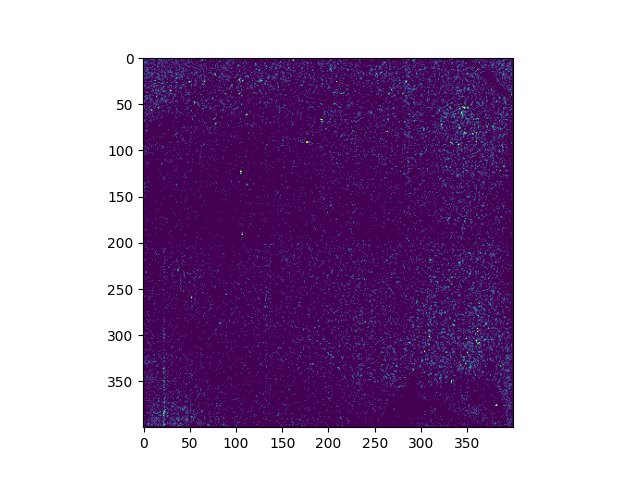

In [423]:
%matplotlib notebook
plt.imshow(sum_single_photons_clustered_2x2_comp, vmax=5)

In [424]:
im = Image.fromarray(sum_single_photons_clustered_2x2_comp.astype(np.uint32))
im.save("220501_pictures/cl_2_th_200_dark_capture/single_count_mask_cl_2_th_200_sum_1000.tiff")


## Loading post acquise pedestal

In [425]:
dark_1 = r'/mnt/nvme_ssd/220307_captures_repeat_from_220304/ped_after_stray_off_resonant_1/*/*'
dark_images = dask_image.imread.imread(dark_1, arraytype="numpy")
avg_dark = da.average(dark_images, axis=0)

In [427]:
avg_dark_comp = avg_dark.compute() # init dark capture from static 10000 frames

In [428]:
imsave("070322_misc_files/ped_1_after_stray.tiff", avg_dark_comp)

## Loading post acquise off resonant captures

In [426]:
images_post = r'/mnt/nvme_ssd/220307_captures_repeat_from_220304/stray_off_resonant_after_ped_1/*/*'
images_2nd_section = dask_image.imread.imread(images_post, arraytype="numpy")

In [429]:
images_2nd_section_without_ped  = images_2nd_section - avg_dark_comp

### 2x2

In [430]:
single_photons_clustered_2x2 = single_photon_mask_var_cl_th_dis(images_2nd_section_without_ped[:10000], 2, 200, 1)

In [431]:
sum_single_photons_clustered_2x2 = single_photons_clustered_2x2.sum(axis=0)

In [432]:
sum_single_photons_clustered_2x2_comp = sum_single_photons_clustered_2x2.compute()

<IPython.core.display.Javascript object>


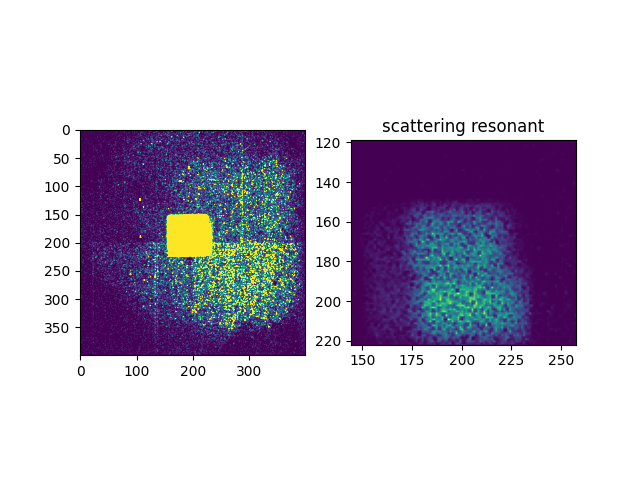

In [441]:
%matplotlib notebook
plt.subplot(1,2,1)
plt.imshow(sum_single_photons_clustered_2x2_comp, vmax=5)
plt.subplot(1,2,2)
plt.title('scattering resonant')
plt.imshow(imread('220501_pictures/scattering/cl_2_th_200_resonance/single_count_mask_cl_2_th_200_sum_10000.tiff'))

# Butterfly

## Loading pedestals

In [443]:
dark_2 = r'/mnt/nvme_ssd/220307_captures_repeat_from_220304/ped_2/*/*'
dark_images = dask_image.imread.imread(dark_2, arraytype="numpy")
avg_dark = da.average(dark_images, axis=0)

In [444]:
avg_dark_comp = avg_dark.compute() # init dark capture from static 10000 frames

In [445]:
imsave("070322_misc_files/ped_2.tiff", avg_dark_comp)

In [446]:
dark_images_1000 = dark_images[:1000] - avg_dark_comp

In [447]:
dark_images_1000_comp = dark_images_1000.compute()

In [448]:
print(f'std {np.std(dark_images_1000_comp)}')

std 20.419523239135742


In [459]:
darks_no_bkgd = dark_images - avg_dark_comp

##  Loading butterfly single shots

In [449]:
butterfly_2 = r'/mnt/nvme_ssd/220307_captures_repeat_from_220304/butterfly_2/*/*'
butterfly = dask_image.imread.imread(butterfly_2, arraytype="numpy")

In [450]:
butterfly_no_bkgd = butterfly - avg_dark_comp

In [451]:
butterfly_100 = butterfly_no_bkgd[:100]
butterfly_100_shots_sum = butterfly_100.sum(axis=0)

In [452]:
butterfly_100_shots_sum_comp = butterfly_100_shots_sum.compute()

<IPython.core.display.Javascript object>


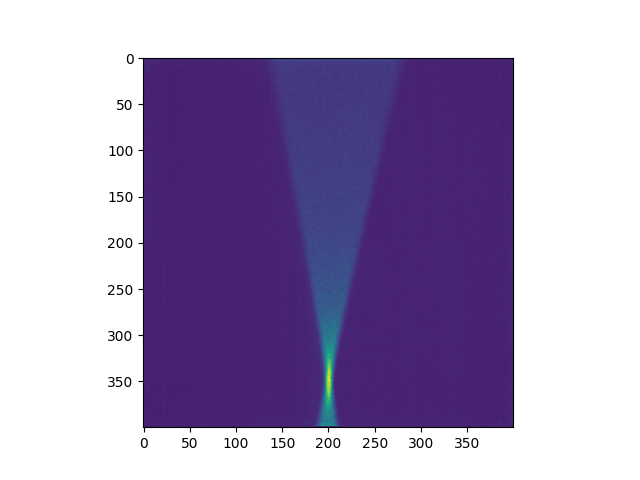

In [453]:
%matplotlib notebook
plt.imshow(butterfly_100_shots_sum_comp)

In [454]:
bins = np.arange(-200, 1000)

In [460]:
hist_butterfly, _ = da.histogram(butterfly_no_bkgd[:10000], bins)
hist_dark_images, _ = da.histogram(darks_no_bkgd[:10000], bins)

In [456]:
hist_butterfly_comp = hist_butterfly.compute()

In [461]:
hist_dark_images_comp = hist_dark_images.compute()

<IPython.core.display.Javascript object>


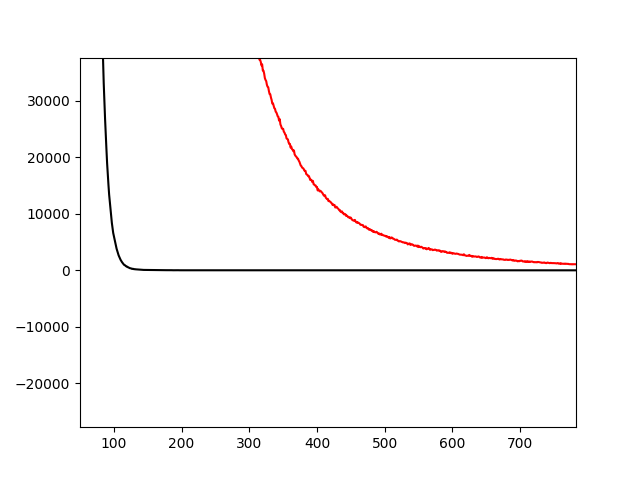

In [463]:
%matplotlib notebook
plot_x_hist = range(-200, 999)
plt.plot(plot_x_hist, hist_butterfly_comp, color = 'red', label='butterfly')
plt.plot(plot_x_hist, hist_dark_images_comp, color = 'black',label = 'pedestal')